# Contenu
-  Préparation des données
- Création d’un modèle simple
- Ajout d’augmentations
- Création d’un réseau de neurones simple
- Quelques techniques magiques (ou avancées)

Nous allons commencer par importer quelques dépendances :

In [92]:
import os
import gc
import re
import cv2
import sys
import glob
import keras

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style  as style

from tqdm  import tqdm
from keras import backend as K
from sklearn.metrics     import accuracy_score, roc_auc_score
from keras.layers        import Dense, Dropout, Flatten, BatchNormalization, GlobalMaxPooling2D
from keras.models        import Sequential, Model, load_model
from keras.callbacks     import ModelCheckpoint,ReduceLROnPlateau, CSVLogger
from keras.activations   import elu
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputSpec

from keras.applications  import MobileNetV2
from keras.optimizers    import Adam
from keras.preprocessing import image
from sklearn.linear_model      import LogisticRegression
from sklearn.model_selection   import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

from keras.optimizers import Adam


In [5]:
# Disable SetCopyWarnings
pd.options.mode.chained_assignment = None

# Preparation des donées

"La première chose que nous allons faire est d'indexer toutes les images que nous avons dans les deux ensembles de données, nous allons utiliser glob pour cela."

In [7]:
data_root = r"C:\Users\HP\Documents\PROJET FIN D'ANNEE\pulmonary-chest-xray-abnormalities"  # à adapter selon ton chemin local

# Compose les chemins vers les fichiers PNG
filelist_montgomery = glob.glob(os.path.join(data_root, "Montgomery/MontgomerySet/CXR_png/*.png"))
filelist_shenzhen = glob.glob(os.path.join(data_root, "ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/*.png"))

# Combine les deux listes
filelist = filelist_montgomery + filelist_shenzhen

 "D'après la documentation, nous savons que l'étiquette est contenue dans le nom du fichier. Pour extraire cette étiquette, nous allons utiliser le module re pour implémenter des expressions régulières (regex) afin d'obtenir l'étiquette."

In [12]:
def extract_label(file_list):
    '''
    Label Extraction Function
    Reads a filename and extracts label from it
    '''
    labels = []
    for file in tqdm(file_list):
        current_label = re.findall('[0-9]{4}_(.+?).png', file)
        labels.append(current_label[0])
    return(labels)

In [14]:
labels = extract_label(filelist)

100%|██████████| 800/800 [00:00<00:00, 160440.05it/s]


Transformons maintenant nos listes en un dataframe

In [20]:
# Create dataframe
full_data = pd.DataFrame(filelist, columns=['filepath'])
full_data['target'] = labels
full_labels         = pd.DataFrame(full_data.pop('target'), columns=['target'])

# Preview dataframe
full_data.head()

,filepath
0,C:\Users\HP\Documents\PROJET FIN D'ANNEE\pulmo...
1,C:\Users\HP\Documents\PROJET FIN D'ANNEE\pulmo...
2,C:\Users\HP\Documents\PROJET FIN D'ANNEE\pulmo...
3,C:\Users\HP\Documents\PROJET FIN D'ANNEE\pulmo...
4,C:\Users\HP\Documents\PROJET FIN D'ANNEE\pulmo...


In [22]:

folder_path = r"C:\Users\HP\Documents\PROJET FIN D'ANNEE\pulmonary-chest-xray-abnormalities\Montgomery\MontgomerySet\CXR_png"
print("Taille du DataFrame full_data:", len(full_data))
print("Aperçu de full_data:")
print(full_data.head())


Taille du DataFrame full_data: 800
Aperçu de full_data:
                                            filepath
0  C:\Users\HP\Documents\PROJET FIN D'ANNEE\pulmo...
1  C:\Users\HP\Documents\PROJET FIN D'ANNEE\pulmo...
2  C:\Users\HP\Documents\PROJET FIN D'ANNEE\pulmo...
3  C:\Users\HP\Documents\PROJET FIN D'ANNEE\pulmo...
4  C:\Users\HP\Documents\PROJET FIN D'ANNEE\pulmo...


In [24]:

folder_path = r"C:\Users\HP\Documents\PROJET FIN D'ANNEE\pulmonary-chest-xray-abnormalities\ChinaSet_AllFiles\ChinaSet_AllFiles\CXR_png"
print("Taille du DataFrame full_data:", len(full_data))
print("Aperçu de full_data:")
print(full_data.head())


Taille du DataFrame full_data: 800
Aperçu de full_data:
                                            filepath
0  C:\Users\HP\Documents\PROJET FIN D'ANNEE\pulmo...
1  C:\Users\HP\Documents\PROJET FIN D'ANNEE\pulmo...
2  C:\Users\HP\Documents\PROJET FIN D'ANNEE\pulmo...
3  C:\Users\HP\Documents\PROJET FIN D'ANNEE\pulmo...
4  C:\Users\HP\Documents\PROJET FIN D'ANNEE\pulmo...


![](https://miro.medium.com/max/1552/1*Nv2NNALuokZEcV6hYEHdGA.png)

"Maintenant, nous avons toutes les données dans un seul dataframe, mais nous devons diviser une partie pour la sélection du modèle (validation / probe) et pour évaluer la généralisation du modèle - *le jeu de test*."

In [31]:
 # Séparer les données en ensembles d'entraînement et de test
train_df,test_df,train_y,test_y = train_test_split(full_data,
                                                   full_labels,
                                                   stratify     = full_labels,
                                                   test_size    = 0.3,
                                                   random_state = 451)

In [35]:
# Réaffecter les étiquettes afin que nous puissions les diviser à nouveau.
train_df['target'] = train_y['target']
test_df['target']  = test_y['target']

In [39]:
# "Divisez à nouveau, afin que nous puissions produire un ensemble de validation."
labels = train_df.pop('target')
train_df, probe_df, train_y, probe_y = train_test_split(train_df,
                                                        labels,
                                                        stratify     = labels,
                                                        test_size    = 0.2,
                                                        random_state = 451)

# Reassemble labels
train_df['target'] = train_y
probe_df['target'] = probe_y

# "Analyse exploratoire"

"Maintenant que nous avons nos ensembles, jetons un œil dessus et vérifions également quelques images."

In [41]:
#"Inspecter le DataFrame d'entraînement"
train_df.head()

,filepath,target
580,C:\Users\HP\Documents\PROJET FIN D'ANNEE\pulmo...,1
7,C:\Users\HP\Documents\PROJET FIN D'ANNEE\pulmo...,0
286,C:\Users\HP\Documents\PROJET FIN D'ANNEE\pulmo...,0
558,C:\Users\HP\Documents\PROJET FIN D'ANNEE\pulmo...,1
643,C:\Users\HP\Documents\PROJET FIN D'ANNEE\pulmo...,1


In [43]:
def plot_multiple_images(image_dataframe, rows = 4, columns = 4, figsize = (16, 20), resize=(1024,1024), preprocessing=None):
    '''
    Plots Multiple Images
    Reads, resizes, applies preprocessing if desired and plots multiple images from a given dataframe
    '''
    image_dataframe = image_dataframe.reset_index(drop=True)
    fig = plt.figure(figsize=figsize)
    ax  = []

    for i in range(rows * columns):
        img = plt.imread(image_dataframe.loc[i,'filepath'])
        img = cv2.resize(img, resize)
        
        if preprocessing:
            img = preprocessing(img)
        
        ax.append(fig.add_subplot(rows, columns, i+1) )
        ax[-1].set_title("Xray "+str(i+1))
        plt.imshow(img, alpha=1, cmap='gray')
    
    plt.show()

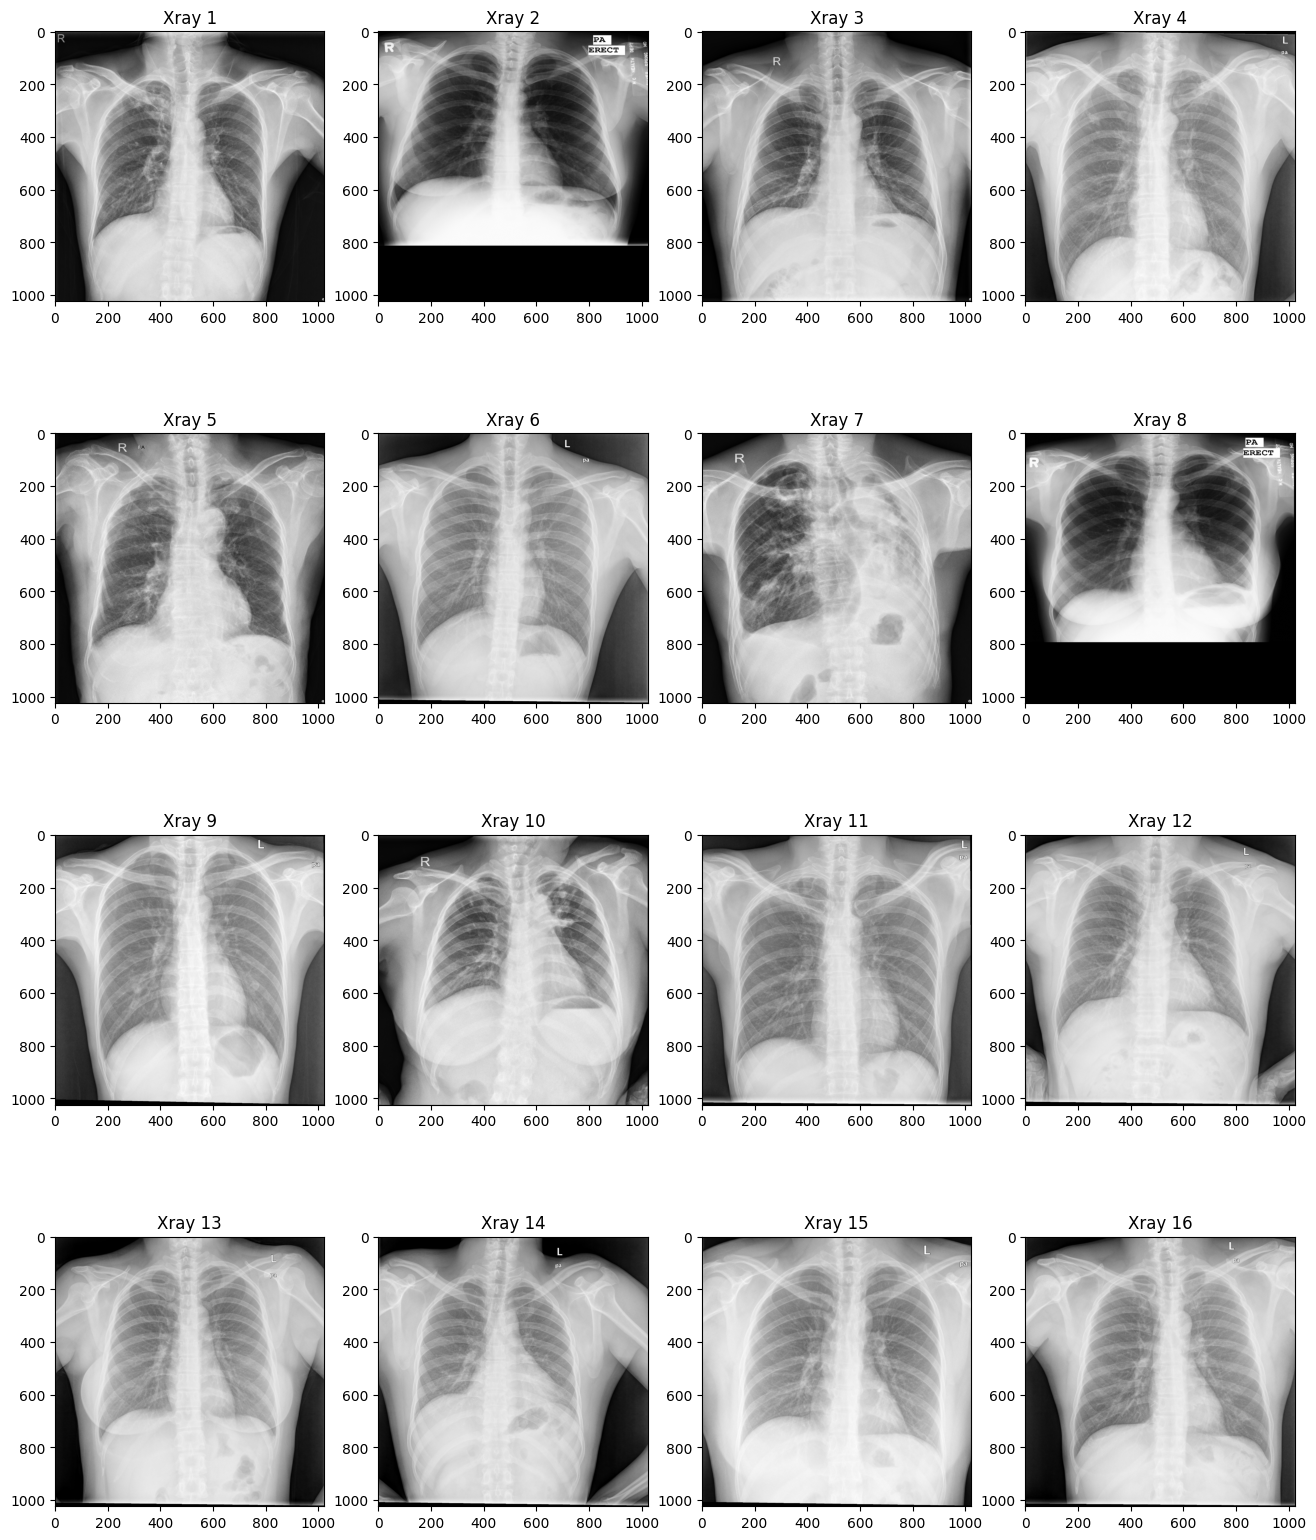

In [45]:
plot_multiple_images(train_df)

Au lieu d'opter pour un modèle complexe, nous commencerons simplement. L'approche la plus simple pourrait être de redimensionner et d'aplatir les pixels, puis de les envoyer à un modèle simple, comme une régression logistique

In [47]:
def load_image(image_path, image_dims = (128,128), grayscale=True, flatten=True, interpolation = cv2.INTER_AREA):
    '''
    Loads an image, resizes and removes redudant channels if so desired
    '''
    image         = cv2.imread(image_path)
    resized_image = cv2.resize(image, image_dims, interpolation = interpolation)
    
    if grayscale:
        resized_image = resized_image[:,:,0]
    
    if flatten:
        resized_image = resized_image.flatten()
    
    return(resized_image)

In [49]:
def create_flattened_dataframe(df, interpolation = cv2.INTER_AREA):
    df     = df.reset_index(drop=True)
    result = pd.DataFrame()
    
    for i in tqdm(range(df.shape[0])):
        im_path = df.loc[i,'filepath']
        current = load_image(im_path, interpolation = interpolation).tolist()
        current = pd.DataFrame(current).T
        result = pd.concat([result, current], ignore_index=True)

    
    return(result)

In [51]:
#Aplatir le DataFrame d'entraînement
train_df_flat = create_flattened_dataframe(train_df)
probe_df_flat = create_flattened_dataframe(probe_df)
test_df_flat  = create_flattened_dataframe(test_df)

100%|██████████| 240/240 [00:43<00:00,  5.54it/s]


In [53]:
train_df_flat.head()

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,63,57,58,58,57,57,57,56,55,56,...,17,18,18,18,18,19,19,19,52,92
1,16,14,14,15,15,16,17,20,24,28,...,0,0,0,0,0,0,0,0,0,0
2,9,9,9,9,9,9,9,9,9,9,...,112,87,29,22,22,21,20,20,52,97
3,118,70,70,66,63,62,59,54,52,51,...,50,51,53,58,58,79,99,107,115,130
4,21,10,6,5,5,6,5,5,5,5,...,51,7,9,11,11,11,11,11,66,83


"Maintenant que notre dataframe aplatie est prête, nous pouvons maintenant créer notre modèle."

# Entraîner un modèle de régression logistique simple

Nous allons créer un modèle de régression logistique, en utilisant `random state` pour assurer la reproductibilité et en fixant le nombre maximal d'itérations à 1000 afin que le modèle ait largement assez d'itérations pour converger

In [58]:
# Créer une régression logistique
logit_model = LogisticRegression(random_state=451, solver='lbfgs', max_iter=1000)
logit_model.fit(train_df_flat, train_df['target'])

LogisticRegression(max_iter=1000, random_state=451)

Notre modèle est maintenant prêt, créons à présent une fonction pour évaluer la précision `(Accuracy)` et l’`AUC` (aire sous la courbe) de notre modèle.

In [61]:
def evaluate_predictions(preds, eval_df = test_df):
    '''
    Evaluate Predictions Function
    Returns accuracy and auc of the model
    '''
    auroc = roc_auc_score(eval_df['target'].astype('uint8'), preds)
    accur = accuracy_score(eval_df['target'].astype('uint8'), preds >= 0.5)
    print('Accuracy: ' + str(auroc))
    print('AUC: ' + str(accur))

In [65]:
# Évaluer les résultats du modèle – Ensemble de validation
logit_preds_val  = logit_model.predict_proba(probe_df_flat)
evaluate_predictions(logit_preds_val[:,1], eval_df = probe_df)

Accuracy: 0.8977272727272727
AUC: 0.8222222222222222


In [67]:
#  Évaluer les résultats du modèle – Ensemble de test
logit_preds  = logit_model.predict_proba(test_df_flat)
evaluate_predictions(logit_preds[:,1], eval_df = test_df)

Accuracy: 0.8528063350930813
AUC: 0.775


Youpi !
Notre régression logistique fonctionne plutôt bien.
Créons maintenant un CNN simple

# Simple CNN - MobileNetV2

Remarque : pour notre dernier exercice, nous avons chargé toutes les images en mémoire, ce qui n’est pas idéal.
Dans le cas de modèles très volumineux, on crée généralement des générateurs qui ne chargent qu’un petit nombre d’images à la fois — d’où l’idée du `batch_size.`

Notre modèle, MobileNetV2, a été conçu avec une taille d’entrée de `224x224`, nous allons donc conserver cette dimension dans notre modèle

In [71]:
batch_size = 32
input_size = (224,224)

Pour nous aider à charger quelques images à la fois, nous allons utiliser le `ImageDataGenerator` de Keras — une classe qui nous permet de charger quelques images à la fois en utilisant sa méthode `flow`, et qui permet aussi d’ajouter des techniques d'augmentation de données.

![](https://rock-it.pl/content/images/2017/05/doggs.jpg)

L'augmentation des données joue un rôle majeur dans l'amélioration de la précision de nos modèles, surtout lorsque le jeu de données est plutôt petit (comme c'est le cas ici). Créons un générateur pour cela

In [78]:
# Create training data generator
train_generator = ImageDataGenerator(rescale = 1./255,
                                     horizontal_flip = True,
                                     zoom_range      = 0.1,
                                     shear_range     = 0,
                                     rotation_range  = 5,
                                     width_shift_range  = 0.05,
                                     height_shift_range = 0.05,
                                     fill_mode = 'constant',
                                     cval      = 0,
                                     preprocessing_function = preprocess_input)

# Create testing data generator
test_generator  = ImageDataGenerator(rescale = 1./255,
                                     preprocessing_function = preprocess_input)

L'augmentation des données est une chose, mais nous devons également configurer la manière dont le `ImageDataGenerator`  parcourra — ou plutôt, "fera défiler" — notre jeu de données

In [83]:
train = train_generator.flow_from_dataframe(dataframe = train_df,
                                    class_mode  = 'binary',
                                    x_col       = 'filepath',
                                    y_col       = 'target',
                                    shuffle     = True,
                                    batch_size  = batch_size,
                                    target_size = input_size,
                                    seed=451)

probe = train_generator.flow_from_dataframe(dataframe = probe_df,
                                    class_mode  = 'binary',
                                    x_col       = 'filepath',
                                    y_col       = 'target',
                                    shuffle     = True,
                                    batch_size  = batch_size,
                                    target_size = input_size,
                                    seed=451)

Found 358 validated image filenames belonging to 2 classes.
Found 90 validated image filenames belonging to 2 classes.


Avec cela terminé, nous pouvons maintenant construire notre réseau de neurones.



In [94]:
# Créer une instance du modèle
model = Sequential()

# Ajouter un modèle pré-entraîné
model.add(MobileNetV2(weights = 'imagenet', input_shape = (224,224,3), include_top=False))

# Add FC and Output layers
model.add(GlobalMaxPooling2D())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=1e-1), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_2          │ (None, 1280)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │        64,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,322,085 (8.86 MB)

 Trainable params: 2,287,973 (8.73 MB)

 Non-trainable params: 34,112 (133.25 KB)

Nous pouvons ajouter des éléments de support à notre entraînement, également appelés dans Keras des `callbacks`. Ils peuvent nous aider à gérer notre taux d'apprentissage, créer des checkpoints de modèle, utiliser TensorBoard et bien d'autres choses.

Pour l'instant, nous allons simplement utiliser le `CSVLogger` , qui enregistre les journaux d'entraînement dans un fichier CSV.

In [97]:
# Create callback
csv_logger = CSVLogger('training_log_mobilenet_try_1.csv')

In [102]:
model.fit(
    train,
    callbacks=[csv_logger],
    epochs=10,
    steps_per_epoch=train.samples // batch_size,
    validation_data=probe,
    validation_steps=probe.samples // batch_size
)


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 134s 13s/step - accuracy: 0.5441 - loss: 0.6910 - val_accuracy: 0.5312 - val_loss: 0.6912
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4688 - loss: 0.6992 - val_accuracy: 0.5312 - val_loss: 0.6912
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 106s 10s/step - accuracy: 0.4983 - loss: 0.6955 - val_accuracy: 0.4531 - val_loss: 0.6938
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5312 - val_loss: 0.6929
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 113s 10s/step - accuracy: 0.5283 - loss: 0.6931 - val_accuracy: 0.4688 - val_loss: 0.6947
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4062 - loss: 0.6973 - val_accuracy: 0.4688 - val_loss: 0.6950
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 112s 10s/step - accuracy: 0.5100 - loss: 0.6939 - val_accuracy: 0.5469 - val_loss: 0.6921
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4688 - loss: 0.6939 - val_accuracy: 0.4844 - v

C'est plutôt étrange, notre modèle semble ne pas être bon du tout... voyons la performance sur l'ensemble de test.

In [112]:
# Create test generator
test = test_generator.flow_from_dataframe(dataframe = test_df,
                                    class_mode  = 'binary',
                                    x_col       = 'filepath',
                                    y_col       = 'target',
                                    shuffle     = False,
                                    batch_size  = batch_size,
                                    target_size = input_size)

# Generate Predictions
preds = model.predict(test)



# Evaluate Model Results
evaluate_predictions(preds)

Found 240 validated image filenames belonging to 2 classes.


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step
Accuracy: 0.5
AUC: 0.5083333333333333


Confirmation : c’est nul ! Jetons un œil à l’historique de l’entraînement

In [123]:
import matplotlib.pyplot as plt

def plot_training_hist(history):
    hist = history.history
    
    fig = plt.figure(figsize=(12, 4))
    plt.title('Loss Plot')
    plt.plot(hist['loss'], '#07e9ed', label='Training Loss')
    plt.plot(hist['val_loss'], '#0791ed', label='Validation Loss')
    plt.ylim([0, 1.2 * max(max(hist['loss']), max(hist['val_loss']))])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [1]:
history = model.fit(...)  # entraîne ton modèle
plot_training_hist(history)


NameError: name 'model' is not defined

Our network is way worse than our logistic regression, how can that be?

In many ways this is a lesson in deep learning vs machine learning.

The idea that deep learning is superior is in many ways inadequate.
And the role of the human behind those models is often more important than the methods thenselves.


Deep learning often overshadows machine learning for it's capacity to accomplish many tasks.
While it certainly has some merit, other aproaches can also be just as good, sometimes better and frequently more `consistent`.

Giba, ranked 1st in kaggle for a couple years mentioned that on a comment once: while deep learning is great it might take you the whole day to make it good
While you can get as of a result with a single hour using ML methods.

Either way, we can improve our CNN model, but don't walk the path of becoming closed minded about CNNs as the single possible solution.
I teach this workshop so that you expand your way of thinking - not constrain it to a single method.

# Simple CNN - Trying Again

Now, let's make some small changes to our model.
We'll just lower the learning rate. Just that.

In [30]:
# Create model instance
model = Sequential()

# Add Pretrained Model
model.add(MobileNetV2(weights = 'imagenet', input_shape = (224,224,3), include_top=False))

# Add FC and Output layers
model.add(GlobalMaxPooling2D())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile Model
model.compile(optimizer=Adam(lr=2e-4), loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                64050     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 2,322,085
Trainable params: 2,287,973
Non-trainable params: 34,112
_________________________________________________________________


In [31]:
# Train model
model.fit_generator(
        train,
        callbacks = [csv_logger],
        epochs    = 15,
        steps_per_epoch  = train.samples // batch_size,
        validation_data  = probe,
        validation_steps = probe.samples // batch_size)

Epoch 1/15
14/14 [==============================] - 87s 6s/step - loss: 1.9470 - acc: 0.6272 - val_loss: 0.6972 - val_acc: 0.7125
Epoch 2/15
14/14 [==============================] - 61s 4s/step - loss: 0.9438 - acc: 0.6964 - val_loss: 0.6004 - val_acc: 0.7250
Epoch 3/15
14/14 [==============================] - 61s 4s/step - loss: 0.5644 - acc: 0.7165 - val_loss: 0.5886 - val_acc: 0.7625
Epoch 4/15
14/14 [==============================] - 63s 5s/step - loss: 0.4839 - acc: 0.7746 - val_loss: 0.4697 - val_acc: 0.7396
Epoch 5/15
14/14 [==============================] - 62s 4s/step - loss: 0.4647 - acc: 0.7969 - val_loss: 0.3816 - val_acc: 0.8125
Epoch 6/15
14/14 [==============================] - 62s 4s/step - loss: 0.4521 - acc: 0.7902 - val_loss: 0.5774 - val_acc: 0.7625
Epoch 7/15
14/14 [==============================] - 58s 4s/step - loss: 0.4456 - acc: 0.7969 - val_loss: 0.5169 - val_acc: 0.7250
Epoch 8/15
14/14 [==============================] - 58s 4s/step - loss: 0.4496 - acc: 0.80

In [32]:
# Create test generator
test = test_generator.flow_from_dataframe(dataframe = test_df,
                                    class_mode  = 'binary',
                                    x_col       = 'filepath',
                                    y_col       = 'target',
                                    shuffle     = False,
                                    batch_size  = batch_size,
                                    target_size = input_size)

# Generate Predictions
preds = model.predict_generator(test, steps= test.samples / batch_size)

# Evaluate Model Results
evaluate_predictions(preds)

Found 240 validated image filenames belonging to 2 classes.
Accuracy: 0.8653098082800778
AUC: 0.7125


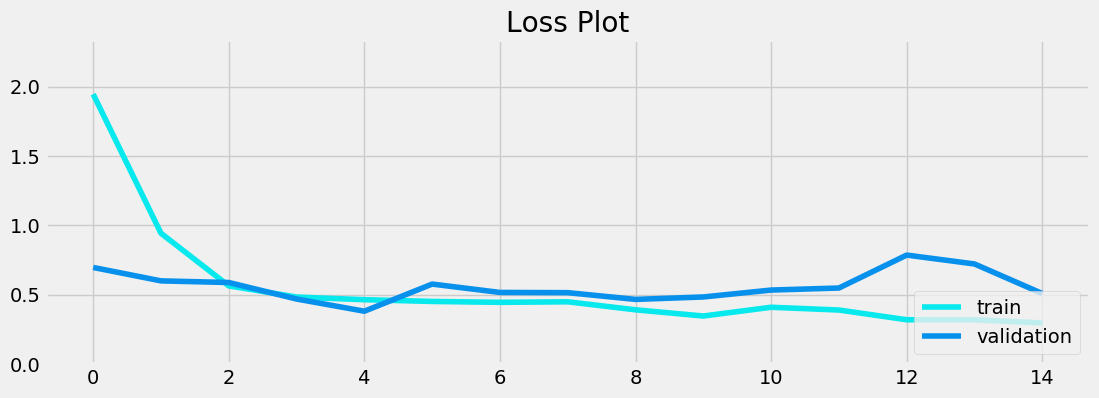

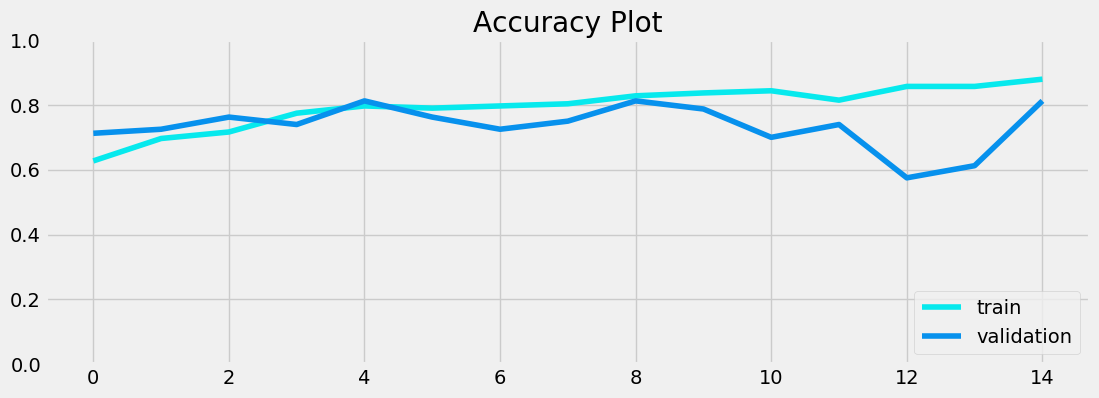

In [33]:
plot_training_hist(model)

Now that's far better, and we managed to improve our previous baseline score from the logistic regression model.

Let's same the model weights to disk so that we can use them later if we want to.

In [34]:
# Save Model Weights as a File
model.save_weights('mobilenetv2_12sep.h5')

That concludes the core part of our workshop.
We created a simple model and used it as baseline to improve creating another simple CNN model.

From here on, we will dive into some neat tricks you can use.

# Viceroy Model

For now we are not allowed to use NN as our final deliverable, so let's dial down a bit.

However...we can use the convolutional layers to better interpret the information and then train a logistic regression on what the previous neural network 'saw'...

Let's try that...

In [3]:
# Create function to extract bottlenet features
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(index=1).output)

# Create training dataset using bottleneck features
intermediate_output = intermediate_layer_model.predict_generator(test_generator.flow_from_dataframe(dataframe = train_df,
                                    class_mode  = 'binary',
                                    x_col       = 'filepath',
                                    y_col       = 'target',
                                    shuffle     = False,
                                    batch_size  = batch_size,
                                    target_size = input_size,
                                    seed        = 451), steps = train_df.shape[0] / batch_size)

intermediate_output_df = pd.DataFrame(intermediate_output)
intermediate_output_df.head()

# Create bottleneck features dataset for testing set
intermediate_output_df_test = pd.DataFrame(intermediate_layer_model.predict_generator(test_generator.flow_from_dataframe(dataframe = test_df,
                                    class_mode  = 'binary',
                                    x_col       = 'filepath',
                                    y_col       = 'target',
                                    shuffle     = False,
                                    batch_size  = batch_size,
                                    target_size = input_size,
                                    seed        = 451), steps = test_df.shape[0] / batch_size))

NameError: name 'Model' is not defined

In [ ]:
# Our new model
viceroy_logreg = LogisticRegression(multi_class='auto', solver='lbfgs', random_state=451, max_iter=1000)
viceroy_logreg.fit(intermediate_output_df, train_y)

# Evaluate Model Results
viceroy_logit_preds  = viceroy_logreg.predict_proba(intermediate_output_df_test)
evaluate_predictions(viceroy_logit_preds[:,1])

# Performing Test Time Augmentation

We can use augmentation to improve the training of neural nets.

We can also use it to 

In [7]:
def TTA_wraper(dl_model, df = test_df, steps = 10, bs = batch_size, sz = input_size, seed = 451):
    # Taken from: https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d
    tta_steps   = steps
    predictions = []

    for i in tqdm(range(tta_steps)):
        tta_pred = dl_model.predict_generator(train_generator.flow_from_dataframe(dataframe = df,
                                        class_mode  = 'binary',
                                        x_col       = 'filepath',
                                        y_col       = 'target',
                                        shuffle     = False,
                                        batch_size  = bs,
                                        target_size = sz,
                                        seed        = seed * i), steps = df.shape[0] / batch_size)
        predictions.append(tta_pred)

    tta_preds = np.mean(predictions, axis=0)
    return(tta_preds)

NameError: name 'test_df' is not defined

In [9]:
tta_preds = TTA_wraper(model)
evaluate_predictions(tta_preds)

NameError: name 'TTA_wraper' is not defined

# Experiment 1: Interpolation

One of the experiments we had was checking how the interpolation can change the result of the model performance.

Let's use a consistent model to check which interpolation produces better scores (and by how much).

In [39]:
all_interpolations = ['cv2.INTER_AREA', 'cv2.INTER_LINEAR', 'cv2.INTER_NEAREST', 'cv2.INTER_CUBIC', 'cv2.INTER_LANCZOS4']

def interpolation_experiment(interpolation_list):
    for current_interpolation in interpolation_list:
        # Create flattenned dataframes
        experimental_train_df_flat = create_flattened_dataframe(train_df, interpolation = eval(current_interpolation))
        experimental_probe_df_flat = create_flattened_dataframe(probe_df, interpolation = eval(current_interpolation))
        experimental_test_df_flat  = create_flattened_dataframe(test_df,  interpolation = eval(current_interpolation))
        
        print(current_interpolation)
        
        # Create Logistic Regression Model
        experimental_logit_model = LogisticRegression(random_state=451, solver='lbfgs', max_iter=1000)
        experimental_logit_model.fit(experimental_train_df_flat, train_df['target'])
        
        # Evaluate Results
        print('--------------------------')
        print('Validation Set Results')
        print('--------------------------')
        # Evaluate Model Results - Testing Set
        experimental_logit_preds  = logit_model.predict_proba(experimental_probe_df_flat)
        evaluate_predictions(experimental_logit_preds[:,1], eval_df = probe_df)
        
        print('--------------------------')
        print('Testing Set Results')
        print('--------------------------')
        # Evaluate Model Results - Testing Set
        experimental_logit_preds  = logit_model.predict_proba(experimental_test_df_flat)
        evaluate_predictions(experimental_logit_preds[:,1], eval_df = test_df)

In [40]:
interpolation_experiment(all_interpolations)

100%|██████████| 240/240 [00:44<00:00,  3.46it/s]


cv2.INTER_AREA


  0%|          | 1/448 [00:00<01:07,  6.65it/s]

--------------------------
Validation Set Results
--------------------------
Accuracy: 0.8376395534290271
AUC: 0.7321428571428571
--------------------------
Testing Set Results
--------------------------
Accuracy: 0.8229369269241457
AUC: 0.7333333333333333


100%|██████████| 240/240 [00:33<00:00,  4.46it/s]


cv2.INTER_LINEAR


  0%|          | 0/448 [00:00<?, ?it/s]

--------------------------
Validation Set Results
--------------------------
Accuracy: 0.8405103668261564
AUC: 0.7767857142857143
--------------------------
Testing Set Results
--------------------------
Accuracy: 0.8251597666018339
AUC: 0.7333333333333333


100%|██████████| 240/240 [00:32<00:00,  4.36it/s]


cv2.INTER_NEAREST


  0%|          | 1/448 [00:00<01:11,  6.22it/s]

--------------------------
Validation Set Results
--------------------------
Accuracy: 0.8094098883572568
AUC: 0.7232142857142857
--------------------------
Testing Set Results
--------------------------
Accuracy: 0.8024451236454571
AUC: 0.7208333333333333


100%|██████████| 240/240 [00:33<00:00,  4.40it/s]


cv2.INTER_CUBIC


  0%|          | 1/448 [00:00<01:06,  6.69it/s]

--------------------------
Validation Set Results
--------------------------
Accuracy: 0.8392344497607656
AUC: 0.7678571428571429
--------------------------
Testing Set Results
--------------------------
Accuracy: 0.8247777160322312
AUC: 0.7333333333333333


100%|██████████| 240/240 [00:33<00:00,  4.43it/s]


cv2.INTER_LANCZOS4
--------------------------
Validation Set Results
--------------------------
Accuracy: 0.8389154704944178
AUC: 0.7678571428571429
--------------------------
Testing Set Results
--------------------------
Accuracy: 0.8249513753820507
AUC: 0.7333333333333333


# Experiment 2: Preprocessing

Soon

# Experiment 3: Lung Segmentation

Soon

# Experiment 4: Lung Detection

Soon

# Visualizing ConvNet Outputs

Soon

# Masked Classification

Unfinished;

Montgommery only

In [41]:
# Compose masks for each lung
left_mask  = glob.glob('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/leftMask/*.png')
right_mask = glob.glob('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/rightMask/*.png')

# Sort all image files so that the filenames match
left_mask.sort()
right_mask.sort()
filelist_montgommery.sort()

In [42]:
# Create dataframe with all Montgommery data
mont_df = pd.DataFrame(filelist_montgommery, columns=['filepath'])
mont_df['target'] = extract_label(filelist_montgommery)
mont_df.head()

100%|██████████| 138/138 [00:00<00:00, 99933.35it/s]


,filepath,target
0,../input/pulmonary-chest-xray-abnormalities/Mo...,0
1,../input/pulmonary-chest-xray-abnormalities/Mo...,0
2,../input/pulmonary-chest-xray-abnormalities/Mo...,0
3,../input/pulmonary-chest-xray-abnormalities/Mo...,0
4,../input/pulmonary-chest-xray-abnormalities/Mo...,0


In [43]:
def fuse_masks(list1,list2, dir_name='fused_images'):
    '''
    Fuse Masks Functions
    Fuses left and right lung mask into a single mask
    '''
    try:
        os.mkdir(dir_name)
    except:
        print('Directory {} already exists'.format(dir_name))
        pass
    
    for i in tqdm(range(len(list1))):
        # Read and fuse arrays together
        array1 = cv2.imread(list1[i])
        array2 = cv2.imread(list2[i])
        fused  = np.add(array1,array2)
        
        # Export to disk
        filename = 'M' + re.findall(r'Mask\/M(.+?)\.png', list1[i])[0] + '.png'
        cv2.imwrite(os.path.join(dir_name, filename), fused)

In [44]:
# Fuse masks together
fuse_masks(left_mask,right_mask)

100%|██████████| 138/138 [01:15<00:00,  1.84it/s]


In [45]:
# Add fused masks to dataframe
fused_masks_list    = glob.glob('fused_images/*.png')
mont_df['maskpath'] = fused_masks_list

In [46]:
# Split Mont. Data into training and testing set
mont_train, mont_test = train_test_split(mont_df,
                                         test_size = 0.3,
                                         stratify  = mont_df['target'],
                                         random_state = 451)

# Pop labels
mont_train_y = mont_train.pop('target')
mont_test_y  = mont_test.pop('target')

In [47]:
def iou_loss_core(y_true, y_pred, smooth=1):
    '''
    IoU, aka jacquard index
    Usable as a metric for keras
    '''
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union        = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou          = (intersection + smooth) / ( union + smooth)
    return(iou)

In [48]:
def dice_coef(y_true, y_pred):
    '''
    Dice Coefficient
    Usable as metric for keras
    '''
    y_true_f     = K.flatten(y_true)
    y_pred_f     = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    result       = (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
    return(result)

In [49]:
# Clean up
!rm -rf fused_images